### Wigner Rotations and Kraus Operators

Let's consider an specific example to implement the simulation of the Wigner rotations using our protocol. If the momentum is in the $x$-direction of the reference frame $\mathcal{O}$ such that initial state is given by
\begin{align}
    |\Psi\rangle = \frac{1}{2}(|p\rangle + |-p\rangle) \otimes (|\uparrow\rangle + |\downarrow\rangle),
\end{align}
where the quantization spin axis is along the $z$-direction. Therefore, both momentum and spin degrees of freedom can be thinking as qubits. Besides, let's consider that the boost is given in the $z$-axis, then $  D(W(\Lambda, p)) =  \cos \frac{\phi}{2} \mathbb{I} + i \sin \frac{\phi}{2} \sigma_y$. Therefore, the state described by $\mathcal{O'}$ and to be prepared in the circuit-based quantum computer using state preparation algorithms is given by
\begin{align}
    |\Psi_{\Lambda}\rangle & = \frac{1}{2} |\Lambda p\rangle \otimes \Big((\cos \frac{\phi}{2} + \sin \frac{\phi}{2})|\uparrow\rangle + (\cos \frac{\phi}{2} - \sin \frac{\phi}{2}) |\downarrow\rangle \Big) \\
    & + \frac{1}{2} |-\Lambda p\rangle \otimes \Big((\cos \frac{\phi}{2} - \sin \frac{\phi}{2})|\uparrow\rangle + (\cos \frac{\phi}{2} + \sin \frac{\phi}{2}) |\downarrow\rangle \Big), 
\end{align}
with $\phi \in [0, \pi/2]$. The corresponding Kraus operators are given by
\begin{align}
  K_0=\frac{1}{\sqrt{2}} \begin{bmatrix} \cos \frac{\phi}{2} & \sin \frac{\phi}{2}\\ - \sin \frac{\phi}{2} & \cos \frac{\phi}{2}  \\ \end{bmatrix}, \ \ K_1 = \frac{1}{\sqrt{2}} \begin{bmatrix} \cos \frac{\phi}{2} & - \sin \frac{\phi}{2}\\ \sin \frac{\phi}{2} & \cos \frac{\phi}{2}  \\ \end{bmatrix}.   \nonumber
\end{align}
such that reduced spin density matrix is
\begin{align}
    \rho_{\Lambda s} = \frac{1}{2} \begin{bmatrix} 1 & \cos \phi \\ \cos \phi & 1  \\ \end{bmatrix}.
\end{align}


Besides, the state $|\Psi_{\Lambda}\rangle$ can be implemented as
\begin{align}
|\Psi_{\Lambda}\rangle & = \Big(|\Lambda p \rangle \langle p| \otimes D(W(p)) + |\Lambda -p \rangle \langle -p| \otimes D(W(-p)) \Big) H \otimes H |0 \rangle_p \otimes | 0 \rangle_s \\
& = \Big(|0\rangle\langle 0| \otimes R_Y^{p \to s}(-\phi) + |1\rangle\langle 1| \otimes R_Y^{p \to s}(\phi)\Big) H \otimes H |0 \rangle_p \otimes | 0 \rangle_s \\
& = CR_Y^{p \to s}(\phi) (\sigma_x \otimes I) CR_Y^{p \to s}(-\phi) (\sigma_x \otimes I)H \otimes H |0 \rangle_p \otimes | 0 \rangle_s
\end{align}

In [1]:
%run init.ipynb
%run ptr.ipynb
%run jupyterQ.ipynb

import qiskit

from qiskit import *

In [2]:
def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C



In [3]:
from qiskit import IBMQ

In [4]:
IBMQ.save_account('407eee087e66afb971221353c2214710f90034665067ef91fefb09e98c6c99d94ff4f4f1c14131a196c09a5d24a4368e1aaa03b0f3d99578f0b8f47071995da6', overwrite = True)

In [5]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [7]:
from qiskit.tools.monitor import backend_overview, backend_monitor

In [8]:
backend_overview()

ibm_oslo                     ibm_nairobi                  ibmq_manila
--------                     -----------                  -----------
Num. Qubits:  7              Num. Qubits:  7              Num. Qubits:  5
Pending Jobs: 106            Pending Jobs: 540            Pending Jobs: 395
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      123.0          Avg. T1:      150.4          Avg. T1:      184.4
Avg. T2:      76.4           Avg. T2:      99.8           Avg. T2:      59.6



ibmq_quito                   ibmq_belem                   ibmq_lima
----------                   ----------                   ---------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 88             Pending Jobs: 51             Pending Jobs: 480
Least busy:   False          Least busy:   True           Least busy:   False
Operational:  True           Oper

In [9]:
device = provider.get_backend('ibmq_belem')

from qiskit.tools.monitor import job_monitor
qr = QuantumRegister(2)
qc = qiskit.QuantumCircuit(qr); 
qc_cal = qiskit.QuantumCircuit(qr)
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'mmc')
cal_job = execute(cal_circuits, backend = device, shots = 8192, optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

635aafcb1c0b4ad213cae0e4
Job Status: job has successfully run


In [15]:
#device = provider.get_backend('ibmq_manila')
import math
qr = QuantumRegister(2); 
qc = qiskit.QuantumCircuit(qr);

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

#qst_qc1 = state_tomography_circuits(qc, [qr[0],qr[1]]);
#job_sim1 = qiskit.execute(qst_qc1, backend = simulator, shots = 8192)


th_min = 0; th_max = math.pi/2; N = 10; dth = (th_max-th_min)/N; th = -dth + 10**-2; thv = np.zeros(N+1)

Cv = np.zeros(N+1)

for j in range(0, N+1):
    qr = QuantumRegister(2)
    qc = qiskit.QuantumCircuit(qr)
    th += dth
    thv[j] = th 
    
    # State preparation
    
    Psi = [0.5*(math.cos(th/2) + math.sin(th/2)),0.5*( math.cos(th/2) - math.sin(th/2)),0.5*(math.cos(th/2) - math.sin(th/2)), 0.5*(math.cos(th/2) + math.sin(th/2))]
    qc.initialize(Psi, [qr[1],qr[0]])
    
    
    #th1 = th; # angles for the state preparation
    #qc.h(qr[0])
    #qc.h(qr[1])

    #qc.cry(th1, qr[0], qr[1]);
    
    #qc.x(qr[1])
    #qc.cry(-th1, qr[0], qr[1]);
    #qc.x(qr[1])
    

    # qstate tomography for rho
    qst_qc1 = state_tomography_circuits(qc, [qr[0],qr[1]]); # defines the qcircuit to make qst
    #qst_qc1 = state_tomography_circuits(qc, qr[1]);
    # simulator
    job_sim1 = qiskit.execute(qst_qc1, Aer.get_backend('qasm_simulator'), shots = 8192); # executes the qst
    qstf_qc_sim1 = StateTomographyFitter(job_sim1.result(), qst_qc1); # fits the data to extract rho
    rho10_prep_sim = qstf_qc_sim1.fit(method = 'lstsq');
    rho0_prep_sim = pTraceR_num(2, 2, rho10_prep_sim)
    
    Cv[j] = coh_l1(rho0_prep_sim) 
    print('th = ', thv[j], 'C = ', Cv[j])
        

    
    
    

    

th =  0.010000000000000009 C =  0.9993420768964267
th =  0.16707963267948966 C =  0.9842502600242576
th =  0.3241592653589793 C =  0.9452589481745232
th =  0.481238898038469 C =  0.8842241504134349
th =  0.6383185307179586 C =  0.7969195693436637
th =  0.7953981633974483 C =  0.6920924725596138
th =  0.9524777960769379 C =  0.5805806611614834
th =  1.1095574287564276 C =  0.44111839823110854
th =  1.2666370614359173 C =  0.2957453168381053
th =  1.423716694115407 C =  0.1444410110548757
th =  1.5807963267948966 C =  0.0073678158123325005


In [18]:
device = provider.get_backend('ibmq_belem')

qr = QuantumRegister(2); 
qc = qiskit.QuantumCircuit(qr);

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

#qst_qc1 = state_tomography_circuits(qc, [qr[0],qr[1]]);
#job_sim1 = qiskit.execute(qst_qc1, backend = simulator, shots = 8192)


th_min = 0; th_max = math.pi/2; N = 10; dth = (th_max-th_min)/N; th = -dth + 10**-2; thv = np.zeros(N+1)

Cve = np.zeros(N+1)

for j in range(0, N+1):
    qr = QuantumRegister(2)
    qc = qiskit.QuantumCircuit(qr)
    th += dth
    thv[j] = th 
    
    # State preparation
    Psi = [0.5*(math.cos(th/2) + math.sin(th/2)),0.5*( math.cos(th/2) - math.sin(th/2)),0.5*(math.cos(th/2) - math.sin(th/2)), 0.5*(math.cos(th/2) + math.sin(th/2))]
    qc.initialize(Psi, [qr[1],qr[0]])
    
    
    #th1 = th; # angles for the state preparation
    #qc.h(qr[0])
    #qc.h(qr[1])

    #qc.cry(th1, qr[0], qr[1]);
    
    #qc.x(qr[1])
    #qc.cry(-th1, qr[0], qr[1]);
    #qc.x(qr[1])
    

    qst_qc = state_tomography_circuits(qc, [qr[0],qr[1]]); # defines the qcircuit to make qst
    
    job_dev1 = qiskit.execute(qst_qc, backend = device, shots = 8192); # executes the qst
    print(job_dev1.job_id());
    job_monitor(job_dev1);
    job_dev_mit1 = meas_filter.apply(job_dev1.result(), method='least_squares'); # error mitigation
    qstf_qc_dev1 = StateTomographyFitter(job_dev_mit1, qst_qc); # fits the data to extract rho
    rho10_prepE = qstf_qc_dev1.fit(method = 'lstsq');
    rho0_prepE = pTraceR_num(2, 2, rho10_prepE)
    
    Cve[j] = coh_l1(rho0_prepE) 
    print('th = ', thv[j], 'C = ', Cve[j])
    


    

635abdc66756f965c9ef4a47
Job Status: job has successfully run
th =  0.010000000000000009 C =  0.9581024769331484
635ac08f0f4ec7aa97650478
Job Status: job has successfully run
th =  0.16707963267948966 C =  0.9295969185155217
635ac38fec45f97dfc8784e4
Job Status: job has successfully run
th =  0.3241592653589793 C =  0.89446149579836
635ac6197a93eed502e25262
Job Status: job has successfully run
th =  0.481238898038469 C =  0.8375596113348722
635ac8933bceadd9ab5eb13d
Job Status: job has successfully run
th =  0.6383185307179586 C =  0.7314688130578234
635acaa4ec45f99e918784f8
Job Status: job has successfully run
th =  0.7953981633974483 C =  0.6388114283160498
635accfa1c0b4a2ab0cae120
Job Status: job has successfully run
th =  0.9524777960769379 C =  0.5332380279825811
635acf99c585ea74f97aac26
Job Status: job has successfully run
th =  1.1095574287564276 C =  0.3821025174135032
635ad2f8c585ea0e197aac2c
Job Status: job has successfully run
th =  1.2666370614359173 C =  0.2547125116856033
6

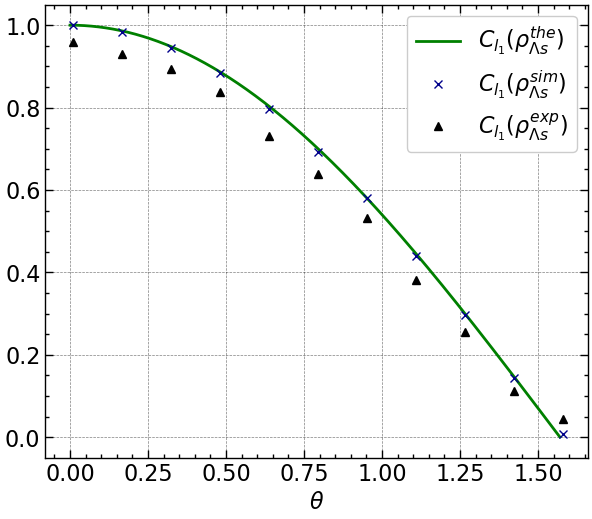

In [19]:
import matplotlib
import numpy as np

plt.style.use(['science', 'notebook', 'grid'])    
x = np.arange(0, np.pi/2, 0.001)
f = np.cos(x)


matplotlib.rcParams.update({'font.size':10}); plt.figure(figsize = (7,6), dpi = 100)
plt.plot(x, f, '-',color = "green", label = r'$C_{l_1}(\rho_{\Lambda s}^{the})$')
plt.plot(thv, Cv, 'x',color = "darkblue", label = r'$C_{l_1}(\rho_{\Lambda s}^{sim})$')
plt.plot(thv, Cve, '^',color = "black", label = r'$C_{l_1}(\rho_{\Lambda s}^{exp})$')

plt.xlabel(r'$\theta$'); 
    #plt.legend(loc = 'center right', bbox_to_anchor=(th_max-0.05, 0.5))
plt.legend(loc = 'best')
    #plt.savefig(path+'psi_plot1.png', format = 'png', dpi = 200)
plt.savefig('wigrot.pdf', format='pdf',dpi = 1200, bbox_inches='tight')

plt.show()